In [1]:
import sys,os
import pickle
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import diffxpy.api as de
import statsmodels.stats.multitest as multi
import pickle

In [6]:
adata = sc.read_h5ad(open("/nfs/team283/aa16/KR_NAS/data/CR_cells_19pcw+14pcw_AnnData_1.h5ad", "rb"))

In [7]:
adata.obs['nuclei'] = adata.obs['nuclei'].astype(float)

In [8]:
cr_cell_nuclei = np.mean(adata.obs['nuclei'].loc[adata.obs['Pool'] == 'CRcells'])
cr_cell_reln = np.mean(adata[adata.obs['Pool'] == 'CRcells',np.array(adata.var == 'RELN')].X)

# Number of nuclei per AOI type:
print('CR cell ROIs mean nuclei:', np.mean(adata.obs['nuclei'].loc[adata.obs['Pool'] == 'CRcells']))
print('Residual ROIs mean nuclei:', np.mean(adata.obs['nuclei'].loc[adata.obs['Pool'] == 'Residual']))
# RELN expression per AOI type:
print('CR cell ROIs mean RELN expression:', np.mean(adata[adata.obs['Pool'] == 'CRcells',np.array(adata.var == 'RELN')].X))
print('Residual ROIs mean RELN expression:', np.mean(adata[adata.obs['Pool'] == 'Residual',np.array(adata.var == 'RELN')].X))
# NR2F1 expression in Frontal vs Occipital:
print('Frontal Cortex ROIs mean NR2F1 expression:', np.mean(adata[adata.obs['Tissue'] == 'Foetal brain (frontal lobe)', np.array(adata.var == 'NR2F1')].X))
print('Occipital Cortex ROIs mean NR2F1 expression:', np.mean(adata[adata.obs['Tissue'] == 'Foetal brain (occipital lobe)', np.array(adata.var == 'NR2F1')].X))

if np.mean(adata.obs['nuclei'].loc[adata.obs['Pool'] == 'CRcells']) != cr_cell_nuclei:
    raise ValueError()
elif np.mean(adata[adata.obs['Pool'] == 'CRcells',np.array(adata.var == 'RELN')].X) != cr_cell_reln:
     raise ValueError()
elif np.mean(adata[adata.obs['Tissue'] == 'Foetal brain (frontal lobe)', np.array(adata.var == 'NR2F1')].X) > np.mean(adata[adata.obs['Tissue'] == 'Foetal brain (occipital lobe)', np.array(adata.var == 'NR2F1')].X):
    raise ValueError()
else:
    print('Input data looks sensible.')

CR cell ROIs mean nuclei: 23.83783783783784
Residual ROIs mean nuclei: 119.99090909090908
CR cell ROIs mean RELN expression: 415.3784
Residual ROIs mean RELN expression: 14.418181
Frontal Cortex ROIs mean NR2F1 expression: 21.074627
Occipital Cortex ROIs mean NR2F1 expression: 36.657536
Input data looks sensible.


In [9]:
adata.var_names = adata.var['SYMBOL']

In [11]:
adata.obs['Pool'].value_counts()

Residual    110
CRcells      74
CRcellsB     40
Rings         1
Name: Pool, dtype: int64

In [14]:
adata.obs['Pool'].loc[adata.obs['Pool'] == 'CRcellsB'] = 'CRcells'

In [15]:
adata = adata[adata.obs['Pool'] == 'CRcells',:]

In [ ]:
adata = adata[adata.obs['Pool'] == 'CRcells',:]

In [16]:
if np.any(adata.obs['Pool'] != 'CRcells'):
    raise ValueError()
elif np.sum(adata.obs['Pool'] == 'CRcells') != len(adata.obs['Pool']):
     raise ValueError()
else:
    print('Input data still makes sense.')
    
adata.obs['Donor'] = [x.split('-')[0] for x in adata.obs['Sample slide ID']]
(adata.obs['Tissue'].astype(str) + ' ' + adata.obs['Pool'].astype(str)
 + ' ' + adata.obs['Donor'].astype(str)).value_counts()

Trying to set attribute `.obs` of view, copying.


Input data still makes sense.


Foetal brain (frontal lobe) CRcells Hob5      16
Foetal brain (occipital lobe) CRcells Hob5    16
Foetal brain (frontal lobe) CRcells Hob8      12
Foetal brain (occipital lobe) CRcells Hob7    12
Foetal brain (temporal lobe) CRcells Hob7     10
Foetal brain (temporal lobe) CRcells Hob8     10
Foetal brain (parietal lobe) CRcells Hob8      9
Foetal brain (temporal lobe) CRcells Hob5      8
Foetal brain (occipital lobe) CRcells Hob8     8
Foetal brain (parietal lobe) CRcells Hob7      7
Foetal brain (frontal lobe) CRcells Hob7       6
dtype: int64

In [18]:
adata.obs['Age'].value_counts()

19 pcw    74
14 pcw    40
Name: Age, dtype: int64

In [27]:
adata_subset

View of AnnData object with n_obs × n_vars = 0 × 18677
    obs: 'Sample_ID', 'slide name', 'scan name', 'panel', 'roi', 'nuclei', 'segment', 'aoi', 'area', 'Type', 'Species', 'Age', 'Background', 'Tissue', 'Slide code', 'Sample slide ID', 'TR', 'Cy5', 'Cy3', 'Pool', 'Collection plate', 'Well', 'PCR plate', 'PCR well', 'Primer plate', 'Primer well', 'I7_Index_ID', 'index', 'I5_Index_ID', 'index2', 'Sanger Sample ID', 'expected_neg', 'ns_sample_ID', 'RawReads', 'TrimmedReads', 'StitchedReads', 'AlignedReads', 'DeduplicatedReads', 'SequencingSaturation', 'UID', 'NegGeoMean_01', 'NegGeoSD_01', 'GeoLOQ2.5_01', 'NormFactorNeg_01', 'NormFactorQ3', 'NormFactorHK', 'GeoLOD2.0_01', 'DetectedGenes2.0', 'batch', 'Donor'
    var: 'SYMBOL'
    obsm: 'negProbes'
    layers: 'X_corrected_cc', 'X_corrected_cc_cpm', 'X_corrected_naive', 'X_corrected_naive_cpm'

In [28]:
adata.X = adata.layers['X_corrected_naive_cpm']
res = {}
count = 0
tissues = np.unique(adata.obs['Age'])
for i in range(len(tissues)):
    for j in range((i+1),len(tissues)):
        print(i)
        print(j)
        if i !=j:
            new_key = str(tissues[i]) + '_vs_' + str(tissues[j])
            adata_subset = adata[[x in (tissues[i], tissues[j]) for x in adata.obs['Age']],:]
            print(new_key)
            print((adata_subset.obs['Age'].astype(str) + ' ' + adata_subset.obs['Pool'].astype(str)
 + ' ' + adata_subset.obs['Donor'].astype(str)).value_counts())
            res[new_key] = de.test.rank_test(
                data=adata_subset,
                grouping="Age",
                is_logged=False
            ).summary()
            
for i in range(len(res.keys())):
    
    print(list(res.keys())[i])
    
    tissue1 = list(res.keys())[i].split('_vs_')[0]
    tissue2 = list(res.keys())[i].split('_vs_')[1]
    print(list(res.keys())[i])
    print(tissue1)
    print(tissue2)
    
    if np.sum(np.array(res[list(res.keys())[i]]['gene']) == np.array(adata.var_names)) != len(adata.var_names):
        raise ValueError()
    
    res[list(res.keys())[i]]['log2_mean_' + tissue1] = np.array(np.log2(np.mean(adata[adata.obs['Age'] == tissue1,].X, axis = 0)))
    res[list(res.keys())[i]]['log2_mean_' + tissue2] = np.array(np.log2(np.mean(adata[adata.obs['Age'] == tissue2,].X, axis = 0)))
    res[list(res.keys())[i]]['log2_fold_change'] =  res[list(res.keys())[i]]['log2_mean_' + tissue1] - res[list(res.keys())[i]]['log2_mean_' + tissue2]
    
    res[list(res.keys())[i]] = res[list(res.keys())[i]].sort_values('pval')
    
res_naive = res

0
1
14 pcw_vs_19 pcw
14 pcw CRcells Hob5    40
19 pcw CRcells Hob8    39
19 pcw CRcells Hob7    35
dtype: int64
14 pcw_vs_19 pcw
14 pcw_vs_19 pcw
14 pcw
19 pcw


In [30]:
pickle.dump(res_naive, open("/nfs/team283/aa16/KR_NAS/0_publication_tables/CR_cells_DE_14pcw_vs_19pcw_naive.p", "wb" ))

In [31]:
adata.X = adata.layers['X_corrected_cc_cpm']
res = {}
count = 0
tissues = np.unique(adata.obs['Age'])
for i in range(len(tissues)):
    for j in range((i+1),len(tissues)):
        print(i)
        print(j)
        if i !=j:
            new_key = str(tissues[i]) + '_vs_' + str(tissues[j])
            adata_subset = adata[[x in (tissues[i], tissues[j]) for x in adata.obs['Age']],:]
            print(new_key)
            print((adata_subset.obs['Age'].astype(str) + ' ' + adata_subset.obs['Pool'].astype(str)
 + ' ' + adata_subset.obs['Donor'].astype(str)).value_counts())
            res[new_key] = de.test.rank_test(
                data=adata_subset,
                grouping="Age",
                is_logged=False
            ).summary()
            
for i in range(len(res.keys())):
    
    print(list(res.keys())[i])
    
    tissue1 = list(res.keys())[i].split('_vs_')[0]
    tissue2 = list(res.keys())[i].split('_vs_')[1]
    print(list(res.keys())[i])
    print(tissue1)
    print(tissue2)
    
    if np.sum(np.array(res[list(res.keys())[i]]['gene']) == np.array(adata.var_names)) != len(adata.var_names):
        raise ValueError()
    
    res[list(res.keys())[i]]['log2_mean_' + tissue1] = np.array(np.log2(np.mean(adata[adata.obs['Age'] == tissue1,].X, axis = 0)))
    res[list(res.keys())[i]]['log2_mean_' + tissue2] = np.array(np.log2(np.mean(adata[adata.obs['Age'] == tissue2,].X, axis = 0)))
    res[list(res.keys())[i]]['log2_fold_change'] =  res[list(res.keys())[i]]['log2_mean_' + tissue1] - res[list(res.keys())[i]]['log2_mean_' + tissue2]
    
    res[list(res.keys())[i]] = res[list(res.keys())[i]].sort_values('pval')
    
res_cc = res

0
1
14 pcw_vs_19 pcw
14 pcw CRcells Hob5    40
19 pcw CRcells Hob8    39
19 pcw CRcells Hob7    35
dtype: int64
14 pcw_vs_19 pcw
14 pcw_vs_19 pcw
14 pcw
19 pcw


/nfs/team283/aa16/software/miniconda3/envs/countcorrect/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log2
/nfs/team283/aa16/software/miniconda3/envs/countcorrect/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log2


In [32]:
pickle.dump(res_cc, open("/nfs/team283/aa16/KR_NAS/0_publication_tables/CR_cells_DE_14pcw_vs_19pcw_cc.p", "wb" ))

Save all data on pairwise differential expression in CR cells in one data frame:

In [58]:
allResults = []

key_wta_array = ['14 pcw_vs_19 pcw']

for j in range(len(key_wta_array)):
    
    print(j)

    res_cc = pickle.load(open("/nfs/team283/aa16/KR_NAS/0_publication_tables/CR_cells_DE_14pcw_vs_19pcw_cc.p", "rb" ))
    res_naive = pickle.load(open("/nfs/team283/aa16/KR_NAS/0_publication_tables/CR_cells_DE_14pcw_vs_19pcw_naive.p", "rb" ))
    
    tissue1_wta = key_wta_array[j].split('_vs_')[0]
    tissue2_wta = key_wta_array[j].split('_vs_')[1]
    

    key_wta = key_wta_array[j]

    res_cc = res_cc[key_wta]
    res_naive = res_naive[key_wta]
    res_tidy = pd.DataFrame(index = list(range(len(res_cc['gene']))), columns = ('gene', 'qval_cc', 'qval_naive',
                                       'log2_mean_wta' + tissue1_wta, 'log2_mean_wta' + tissue2_wta,                                        
                                       'log2fc_cc', 'log2fc_naive', 'log2fc_sc'))
    
    print(key_wta)
    print(tissue1_wta)
    print(tissue2_wta)
    
    for i in range(len(res_cc['gene'])):
        res_tidy['gene'].iloc[i]  = res_cc['gene'].iloc[i]
        
        index_naive = res_naive['gene'] == res_cc['gene'].iloc[i]
        
        if res_naive['gene'].loc[index_naive].iloc[0] != res_cc['gene'].iloc[i]:
            print(res_naive['gene'].loc[index_naive])
            print(res_cc['gene'].iloc[i])
            raise ValueError()
        
        res_tidy['qval_cc'].iloc[i] = res_cc['qval'].iloc[i]
        res_tidy['qval_naive'].iloc[i]  = res_naive['qval'].loc[index_naive].iloc[0]
        
        res_tidy['log2_mean_wta' + tissue1_wta].iloc[i] = res_cc['log2_mean_' + tissue1_wta].iloc[i]
        res_tidy['log2_mean_wta' + tissue2_wta].iloc[i] = res_cc['log2_mean_' + tissue2_wta].iloc[i]
        
        res_tidy['log2fc_cc'].iloc[i]  = res_cc['log2_fold_change'].iloc[i]
        res_tidy['log2fc_naive'].iloc[i]  = res_naive['log2_fold_change'].loc[index_naive].iloc[0]
            
    allResults += [res_tidy]

0
14 pcw_vs_19 pcw
14 pcw
19 pcw


In [59]:
pickle.dump(allResults, open("/nfs/team283/aa16/KR_NAS/0_publication_tables/CR_cells_DE_14pcw_vs_19pcw_allResults.p", "wb" ))

In [60]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('/nfs/team283/aa16/KR_NAS/0_publication_tables/CR_cell_DE_14pcw_vs_19pcw_results.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
for i in range(len(allResults)):
    allResults[i].to_excel(writer, sheet_name=key_wta_array[i])

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [120]:
allResults[0] = allResults[0].sort_values('log2fc_cc')
genesOfInterest = np.array(allResults[0].loc[[allResults[0]['qval_cc'].iloc[i] < 0.01 and np.abs(allResults[0]['log2fc_cc'].iloc[i]) > 2
                 and np.any(np.array([allResults[0]['log2_mean_wta19 pcw'].iloc[i], allResults[0]['log2_mean_wta14 pcw'].iloc[i]]) > 6) for i in range(len(allResults[0]['qval_cc']))],:]['gene'])
genesOfInterest

array(['ATF5', 'PRDX3', 'ARL17B', 'NPC2', 'MOCS3', 'SHC3', 'VANGL2',
       'VGF', 'DUSP1', 'SUPT7L', 'IFIT1', 'EGR1', 'USP9Y', 'RPS4Y1'],
      dtype=object)

In [121]:
np.array([allResults[0]['log2_mean_wta19 pcw'].iloc[i], allResults[0]['log2_mean_wta14 pcw'].iloc[i]])

array([5.72503555, 4.09933559])

In [122]:
adata.obs['Tissue'] = adata.obs['Tissue'].astype(str)
adata.obs['Tissue'].loc[adata.obs['Tissue'] == 'Foetal brain (occipital lobe)'] = 'Occipital'
adata.obs['Tissue'].loc[adata.obs['Tissue'] == 'Foetal brain (frontal lobe)'] = 'Frontal'

Trying to set attribute `.obs` of view, copying.
/nfs/team283/aa16/software/miniconda3/envs/countcorrect/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [123]:
adata = adata[[adata.obs['Tissue'].iloc[i] in ('Occipital', 'Frontal') for i in range(len(adata.obs['Tissue']))],:]

In [124]:
geneNames = adata.var_names[[g in genesOfInterest for g in adata.var_names]]
counts_cpm = adata.layers['X_corrected_cc_cpm'][:,[g in genesOfInterest for g in adata.var_names]]
regions  = adata.obs['Tissue']

In [125]:
tab = pd.DataFrame(index = range(np.prod(np.shape(counts_cpm))), columns = ('gene', 'counts', 'Region'))
n_genes = np.shape(counts_cpm)[1]
n_samples = np.shape(counts_cpm)[0]
for i in range(len(geneNames)):
    tab.iloc[(i*n_samples):((i+1)*n_samples),0] = geneNames[i]
    tab.iloc[(i*n_samples):((i+1)*n_samples),1] = counts_cpm[:,i] + 5
    tab.iloc[(i*n_samples):((i+1)*n_samples),2] = regions

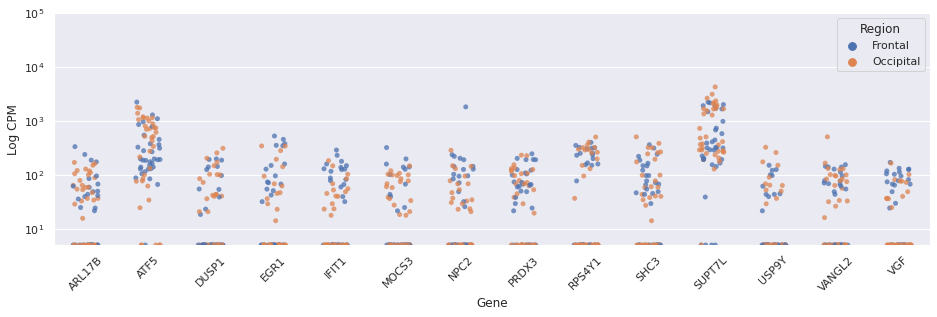

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15.7,4.27)})
sns.stripplot(x="gene", y="counts", hue="Region", data=tab, alpha = 0.75, jitter=0.2)
plt.yscale('log')
plt.ylabel('Log CPM')
plt.xlabel('Gene')
plt.ylim(5, 10**5)
plt.xticks(rotation=45)
plt.show()